In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib inline

# Dusty Torus Model

This notebook visualises the `clumpy` models and saves a (somewhat arbitrary) torus template to use with AGNFinder. I'll extend this to include inclination, and maybe rethink the other params, but not until everything else works

In [25]:
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import dill

In [11]:
sns.set_context('notebook')

In [12]:
# downloaded from https://www.clumpy.org/pages/seds.html
# https://arxiv.org/abs/0806.0511
# https://iopscience.iop.org/article/10.1086/590483/pdf

In [13]:
data_loc = '/media/walml/beta/agnfinder/clumpy_models_201410_tvavg.hdf5'

In [14]:
with h5py.File(data_loc, 'r') as f:
    print(f.keys())
    wavelengths = f['wave'][...] * 1e4  # microns to angstroms
    opening_angle = f['sig'][...]
    inclination = f['i'][...]
    n0 = f['N0'][...]
    q = f['q'][...]
    y = f['Y'][...]
    tv = f['tv'][...]
    seds = f['flux_toragn'][...]

<KeysViewHDF5 ['N0', 'Y', 'f2', 'flux_tor', 'flux_toragn', 'i', 'lam10', 'lam18', 'ptype1', 'q', 's10', 's18', 'sig', 'tv', 'wave']>


Opening angle, and the other params, are calculated on a grid

In [15]:
seds.shape

(1247400, 119)

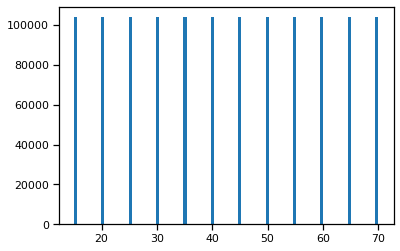

In [16]:
_ = plt.hist(opening_angle, bins=100)

Let's pick 30deg opening angle, at S.F's suggestion.

In [17]:
def get_log_space_median(x):
    return 10 ** np.median(np.log10(x), axis=0)

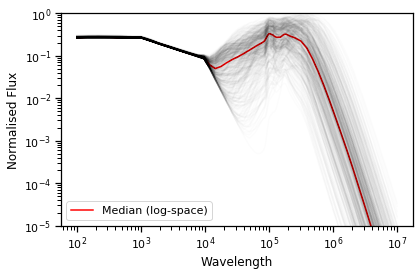

In [18]:
median_sed = get_log_space_median(seds)
plt.loglog(wavelengths, median_sed, 'r', label='Median (log-space)')
random_indices = np.random.choice(len(seds), 500)
random_seds = seds[random_indices]
for s in random_seds:
    plt.loglog(wavelengths, s, color='k', alpha=0.01)
plt.xlabel('Wavelength')
plt.ylabel('Normalised Flux')
plt.ylim([10**-5, 1])
plt.legend()
plt.tight_layout()

In [19]:
desired_opening_angle = opening_angle == 30

In [20]:
unique_inclinations = np.unique(inclination[desired_opening_angle])  # filter doesn't actually matter
unique_inclinations

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=int32)

### If select the opening angle, vary inclination, and marginalise (log median) over other params, what do the SEDs look like?
(i.e. what effect does inclination typically have, for our opening angle)

Text(0, 0.5, 'Flux')

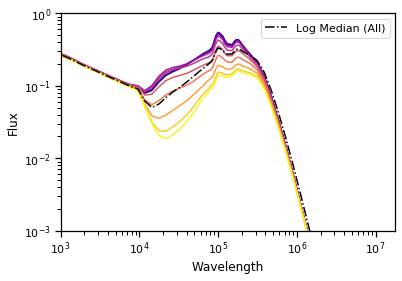

In [21]:
for inc in unique_inclinations:
    plt.loglog(wavelengths, get_log_space_median(seds[desired_opening_angle & (inclination == inc)]), color=cm.plasma(inc / unique_inclinations.max()))
# plt.loglog(wavelengths, selected_sed, 'k--', label=r'Figure $\theta$')
plt.loglog(wavelengths, get_log_space_median(seds), 'k-.', label=r'Log Median (All)')
plt.legend()
plt.xlim([10**3, None])
plt.ylim([10**-3, 1])
plt.xlabel('Wavelength')
plt.ylabel('Flux')

Inclination controls the 10 * 4 break: does flux immediately rise again, or does it dip sharpyly first?

In [22]:
# assert inclination_at_desired_opening.min() == 0
# normalised_inclination = inclination_at_desired_opening / inclination_at_desired_opening.max()
# assert normalised_inclination.min() == 0
# assert normalised_inclination.max() == 1.

Pick some fixed parameters using the values typically assumed in the sim author's paper, when varying one param and fixing the rest.

In [23]:
figure_suggested_params = (n0 == 5) & (opening_angle == 30) & (q == 2) & (y == 30) & (tv == 60)
figure_suggested_params.sum()

10

In [26]:
pd.unique(inclination[figure_suggested_params])

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=int32)

10 possibilities, one for each inclination value. Stepping though them, what do they look like?

Text(0, 0.5, 'Flux')

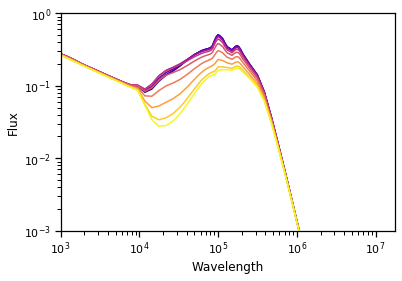

In [27]:
unique_inclinations = inclination[figure_suggested_params]
for inc in unique_inclinations:
    plt.loglog(wavelengths, get_log_space_median(seds[figure_suggested_params & (inclination == inc)]), color=cm.plasma(inc / unique_inclinations.max()))
# plt.loglog(wavelengths, selected_sed, 'k--', label=r'Figure $\theta$')
# plt.loglog(wavelengths, get_log_space_median(seds[figure_suggested_params]), 'k-.', label=r'Log Median (All)')
# plt.legend()
plt.xlim([10**3, None])
plt.ylim([10**-3, 1])
plt.xlabel('Wavelength')
plt.ylabel('Flux')

Really quite similar, to an amateur at least. Our fixed parameters seem to not have nearly as much effect as inclination. Good times.

### Creating the model

Let's make these 10 SEDs into a smooth callable func(wavelength, inclination), interpolating in log space

In [28]:
from scipy.interpolate import interp2d

In [29]:
func = interp2d(x=np.log10(wavelengths), y=inclination[figure_suggested_params], z=np.log10(seds[figure_suggested_params]))

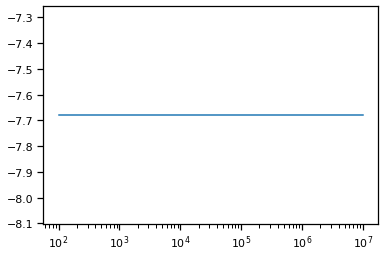

In [30]:
plt.semilogx(wavelengths, func(wavelengths, 50))

In [31]:
func(x=np.log10(wavelengths)[0:2], y=inclination[figure_suggested_params][0])

array([-0.55392909, -0.55005902])

In [32]:
np.log10(seds[figure_suggested_params])[0:2][0]

array([-0.5539291 , -0.550059  , -0.5492891 , -0.55098474, -0.5536182 ,
       -0.5611414 , -0.5608253 , -0.60223377, -0.6478175 , -0.6981023 ,
       -0.7418418 , -0.7840982 , -0.82856613, -0.87192404, -0.9143527 ,
       -0.92701524, -0.95663774, -0.99396205, -1.0077559 , -1.0893222 ,
       -1.0450343 , -0.9370422 , -0.8566729 , -0.7977842 , -0.72815835,
       -0.6478175 , -0.5734888 , -0.52244467, -0.51385295, -0.5071    ,
       -0.5007254 , -0.4958011 , -0.49106646, -0.4873156 , -0.4805658 ,
       -0.47469598, -0.46306297, -0.44490555, -0.43663758, -0.41930306,
       -0.4030732 , -0.39083263, -0.3792395 , -0.3675427 , -0.35615268,
       -0.34543842, -0.33348203, -0.32468   , -0.31939256, -0.31407923,
       -0.30680084, -0.30007562, -0.29843202, -0.29955593, -0.3007695 ,
       -0.30373102, -0.30662483, -0.3095381 , -0.3139897 , -0.31839702,
       -0.32284948, -0.32725582, -0.33180052, -0.33526403, -0.33885014,
       -0.34246612, -0.34775364, -0.3532043 , -0.37181547, -0.39

In [33]:
x = np.log10(wavelengths)
# y = np.linspace(50, 60)


In [34]:
# x.shape, y.shape, z.shape

In [ ]:
import matplotlib as mpl

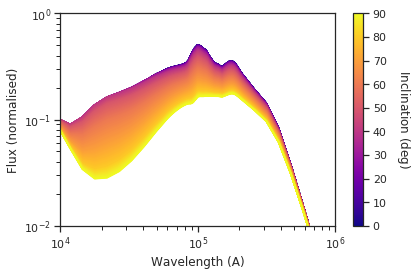

In [71]:
sns.set_context('notebook')
# sns.set(font_scale=1.3)
sns.set_style('ticks')

inclinations_y = np.linspace(0, 90, 300)  # 0 through 90 are the possible inclination values
for y in inclinations_y:
    z = func(x=x, y=y)
    plt.loglog(10 ** x, 10 ** z, color=cm.plasma(y / inclinations_y.max()))
plt.xlim([10**4, 10**6])
plt.ylim([10**-2, 1])
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (normalised)')

cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.plasma, norm = mpl.colors.Normalize(vmin=0.,vmax=inclinations_y.max())))

cbar_label = r'Inclination ($\deg$)'
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel(cbar_label, rotation=270)
# cbar.ax.text(0., 0., cbar_label, ha='center', va='center')
plt.tight_layout()
plt.savefig('torus_inclination.png')
plt.savefig('torus_inclination.pdf')

In [ ]:

# # enforce no flux below 100 angstroms
# df = df.append({'wavelength': 99.99, 'flux': 1e-15}, ignore_index=True)
# df = df.append({'wavelength': 1e-2, 'flux': 1e-15}, ignore_index=True)  
# # enforce no flux above 1e7 angstroms
# df = df.append({'wavelength': 10000000.1, 'flux': 1e-15}, ignore_index=True)
# df = df.append({'wavelength': 1e13, 'flux': 1e-15}, ignore_index=True) 


In [ ]:
!pwd

In [ ]:
# os.chdir('/home/mike/repos/agnfinder')

In [ ]:
# with open('data/torus_model_with_inclination.dill', 'wb') as f:
#     dill.dump(func, f)